In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import numpy as np
import healpy as hp
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle
import corner
import os

from scipy import optimize
from scipy.stats import poisson

import jax
import jax.numpy as jnp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../utils/matplotlibrc')

from utils import ed_fcts_amarel as ef

/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# INPUT CELL

# load GPU
gpu_id = '1'

# name of the default simulation
sim_name = 'canon_g1p2_fla_v2'

# templates to build synthetic data (other option to do this below)
rig_temp_select = ['iso', 'psc', 'bub'] # 'iso', 'psc', 'bub'
hyb_temp_select = ['pib','ics', 'blg'] # pib, ics, blg
var_temp_select = ['nfw'] # nfw, dsk

In [3]:
# load GPU
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

# directory where the data and fits are stored
data_dir = ef.load_data_dir(sim_name)

# load fitting parameters used to define the synthetic data
import importlib
sys.path.append(data_dir)
module = importlib.import_module('sim_settings')
globals().update(vars(module)) # loads all variables from module

# load the svi results
file_name = ('ebin' + str_ebin + '_smp_svi_' + 
             str_lr + '_' + str_n_steps + '_' + 
                str_guide + '_' + str_num_particles + '_' + str_svi_seed + '.p')

samples, svi_results = pickle.load(open(data_dir + file_name, 'rb'))

In [4]:
from models.poissonian_gp import EbinPoissonModel

ie = ebin
ebinmodel = EbinPoissonModel(
        rig_temp_list = rig_temp_list, # 'iso', 'psc', 'bub'
        hyb_temp_list = hyb_temp_list, # pib, ics, blg
        var_temp_list = var_temp_list, # nfw, dsk
        is_gp = is_gp,
        data_file = data_file,
        nfw_gamma = nfw_gamma,
        dif_names = dif_names,
)
ebinmodel.config_model(ebin=ie)
nside = ebinmodel.nside
# mask_p = ebinmodel.mask_roi_arr[ie]
mask_p = np.array([False for i in range(hp.nside2npix(nside))])

LaTeX Table of Parameter Means
Generate Table with OverLeaf using Output Below:

\begin{table}[htb]
\centering
\begin{tabular}{|c|c|}
\hline
Quantity & Value \\
\hline
S_{blg} & 0.263 \\
S_{bub} & 1.359 \\
S_{ics} & 5.680 \\
S_{iso} & 1.884 \\
S_{nfw} & 0.360 \\
S_{pib} & 14.448 \\
S_{psc} & 3.666 \\
\hline
\end{tabular}
\end{table}


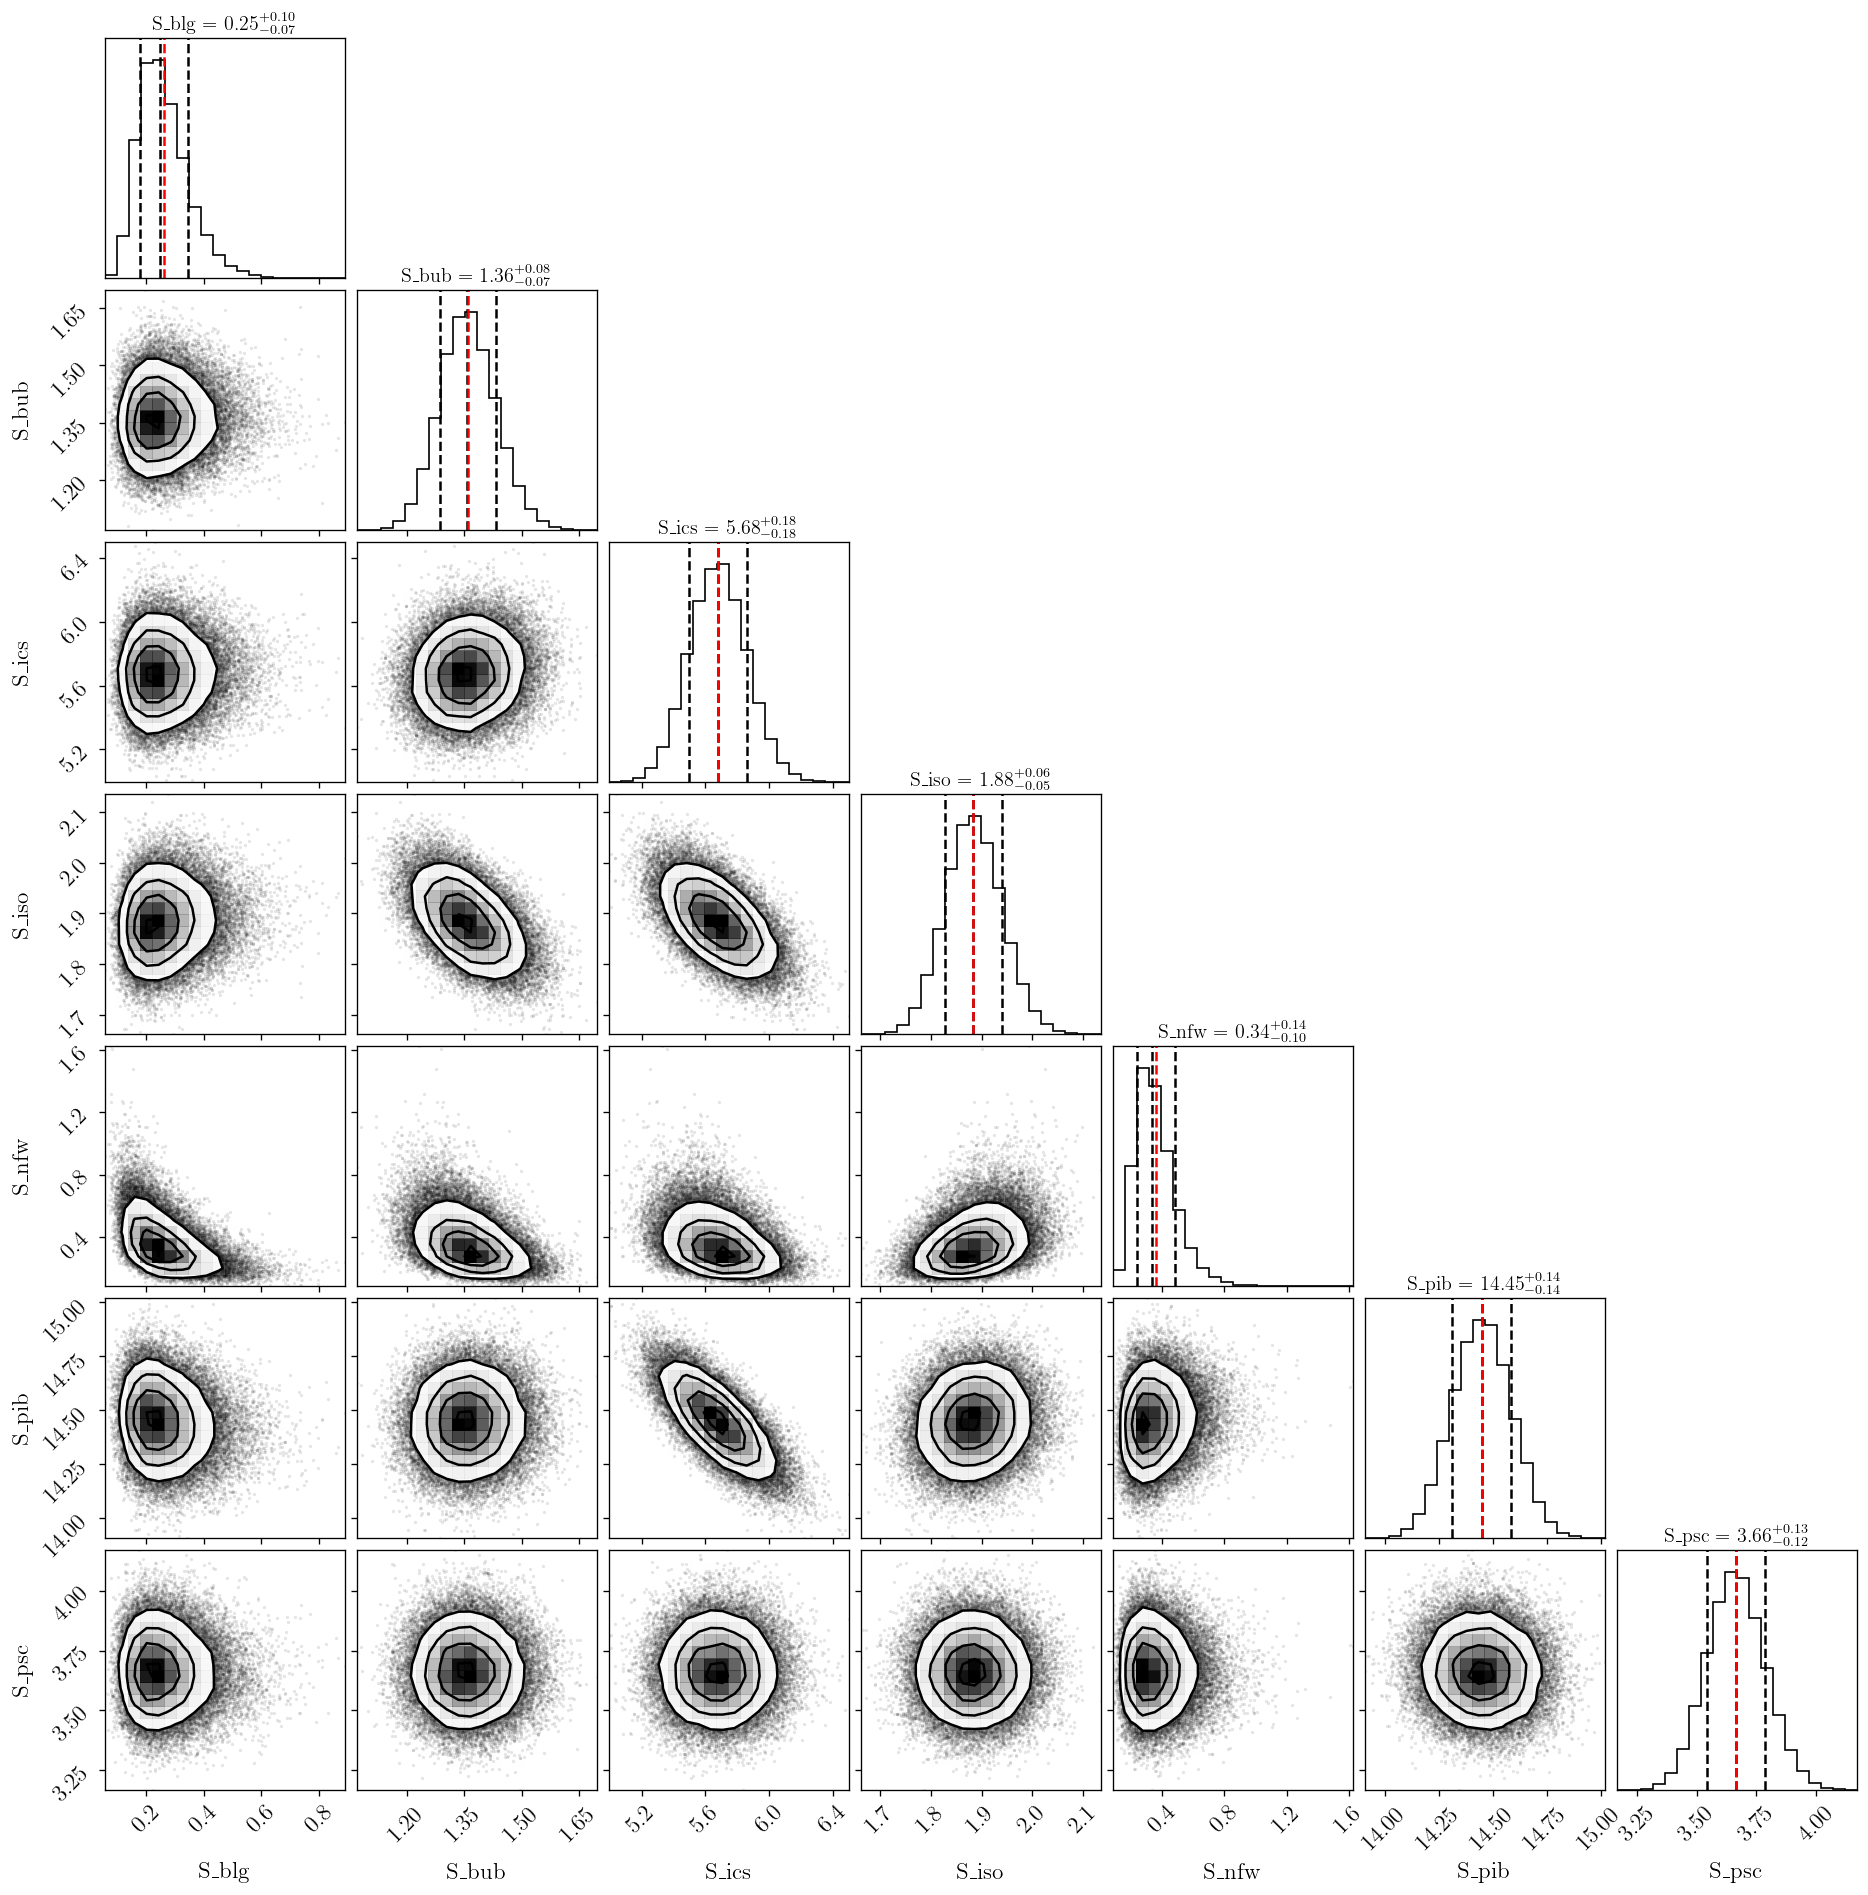

In [5]:
# simulated data will consist of mean normalizations from fit

S_blg = np.mean(samples['S_blg'])
S_bub = np.mean(samples['S_bub'])
S_psc = np.mean(samples['S_psc'])
S_iso = np.mean(samples['S_iso'])
S_nfw = np.mean(samples['S_nfw'])
S_pib = np.mean(samples['S_pib'])
S_ics = np.mean(samples['S_ics'])
if nfw_gamma == 'vary':
    gamma = np.mean(samples['gamma'])
else:
    gamma = nfw_gamma

# corner plot and latex table of means

fig = ef.make_corner_plots(samples, with_mean_vlines = True, print_latex_means = True)

/data/edr76/gce-gp/diffuse_model_tests/../utils/ed_fcts_amarel.py:665: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))


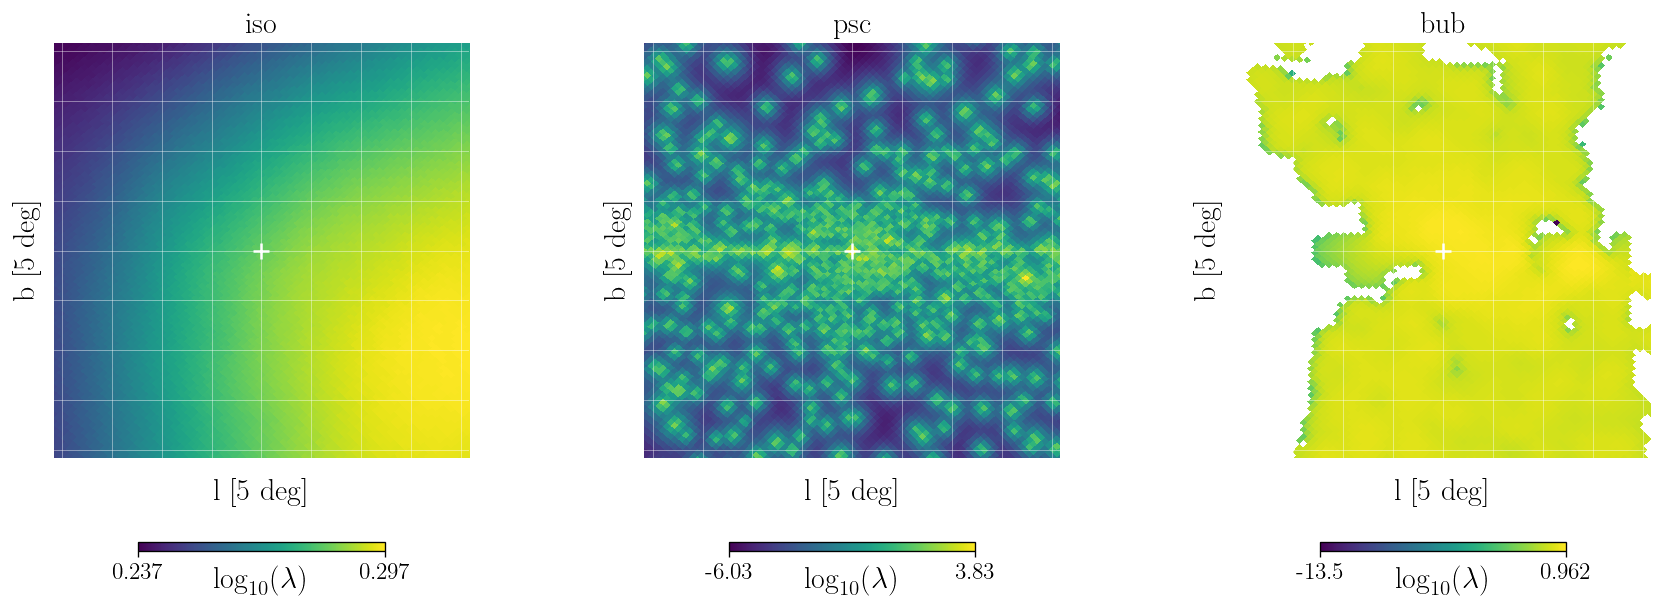

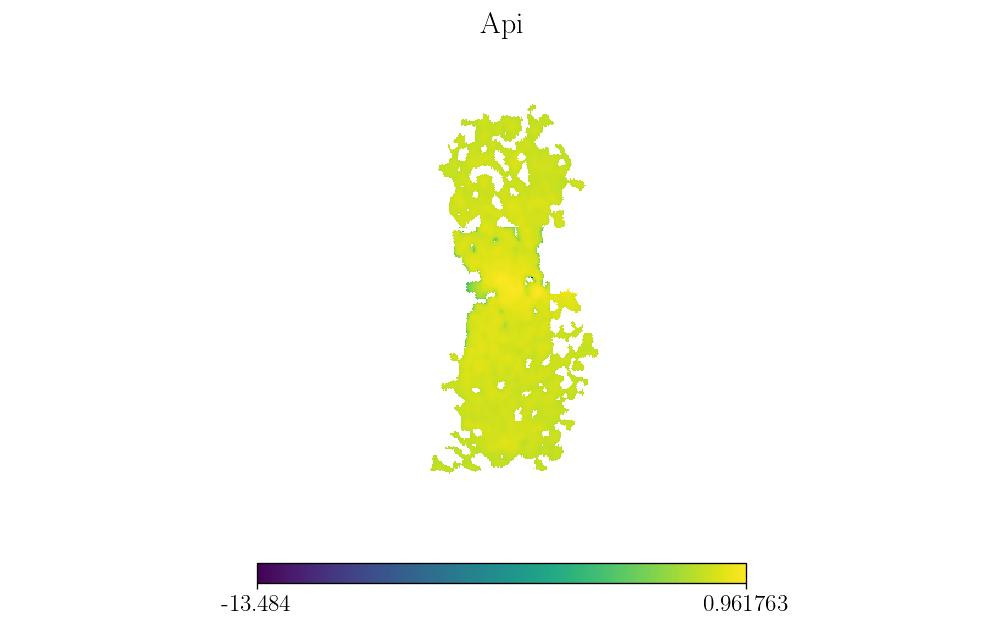

In [6]:
# load the rigid templates

temp_iso = S_iso * jnp.asarray(ebinmodel.temps['iso'].at_bin(ie, mask=mask_p))
temp_psc = S_psc * jnp.asarray(ebinmodel.temps['psc'].at_bin(ie, mask=mask_p))
temp_bub = S_bub * jnp.asarray(ebinmodel.temps['bub'].at_bin(ie, mask=mask_p))

rig_temps = [temp_iso, temp_psc, temp_bub]
rig_names = ['iso', 'psc', 'bub']
rig_temps_hp = []

fig = plt.figure(figsize=(18, 6), dpi= 120)
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    plt.axes(ax)
    rig_temps_hp.append(ef.convert_masked_array_to_hp_array(rig_temps[i], mask_p, log_option = True, nside=nside))
    ef.gnomview_plot(rig_temps_hp[i], title = rig_names[i])
hp.mollview(rig_temps_hp[2], title="Api")

/data/edr76/gce-gp/diffuse_model_tests/../utils/ed_fcts_amarel.py:665: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))


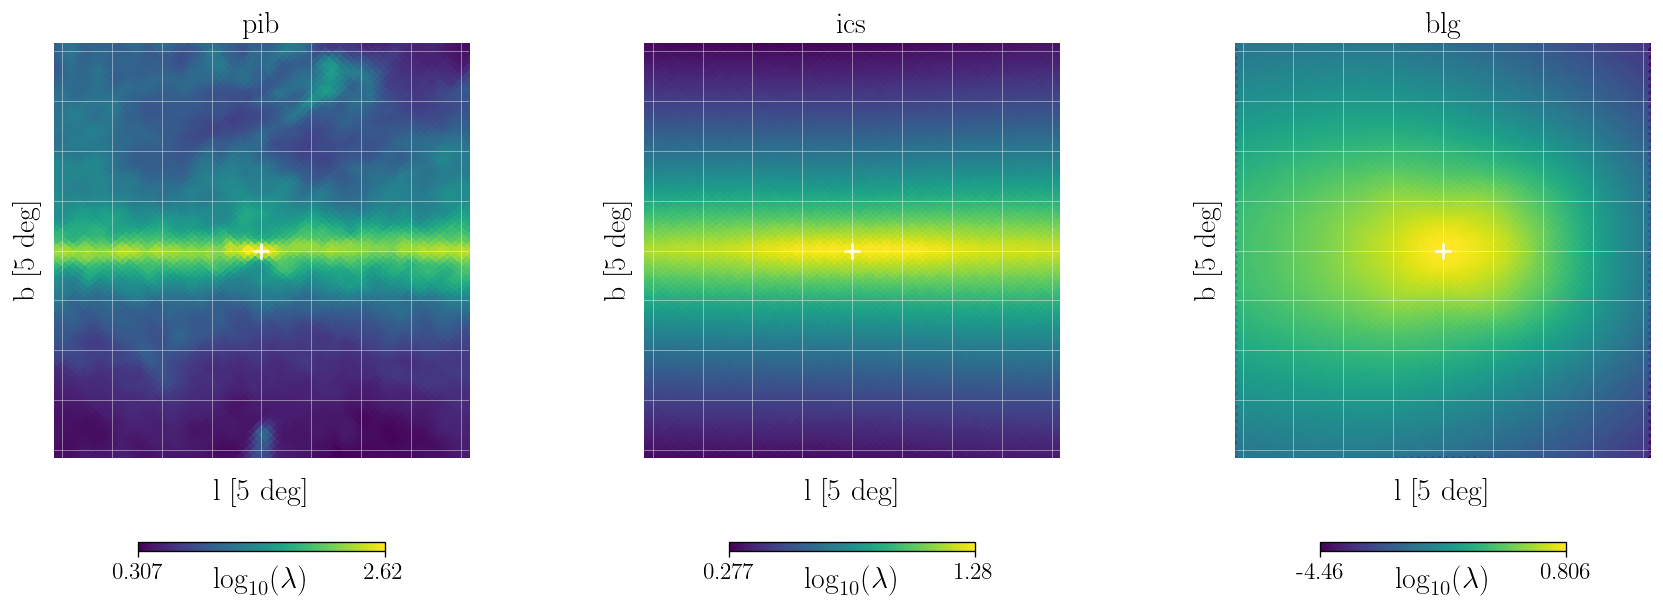

In [7]:
# load the hybrid templates 

pib_temps_at_bin = jnp.asarray([pib_temp.at_bin(ie, mask=mask_p) for pib_temp in ebinmodel.pib_temps])
ics_temps_at_bin = jnp.asarray([ics_temp.at_bin(ie, mask=mask_p) for ics_temp in ebinmodel.ics_temps])
blg_temps_at_bin = jnp.asarray([blg_temp.at_bin(ie, mask=mask_p) for blg_temp in ebinmodel.blg_temps])

temp_pib = S_pib * pib_temps_at_bin[0]
temp_ics = S_ics * ics_temps_at_bin[0]
temp_blg = S_blg * blg_temps_at_bin[0]

hyb_temps = [temp_pib, temp_ics, temp_blg]
hyb_names = ['pib', 'ics', 'blg']
hyb_temps_hp = []

fig = plt.figure(figsize=(18, 6), dpi= 120)
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    plt.axes(ax)
    hyb_temps_hp.append(ef.convert_masked_array_to_hp_array(hyb_temps[i], mask_p, log_option = True, nside=nside))
    ef.gnomview_plot(hyb_temps_hp[i], title = hyb_names[i])

/data/edr76/gce-gp/diffuse_model_tests/../utils/ed_fcts_amarel.py:665: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))


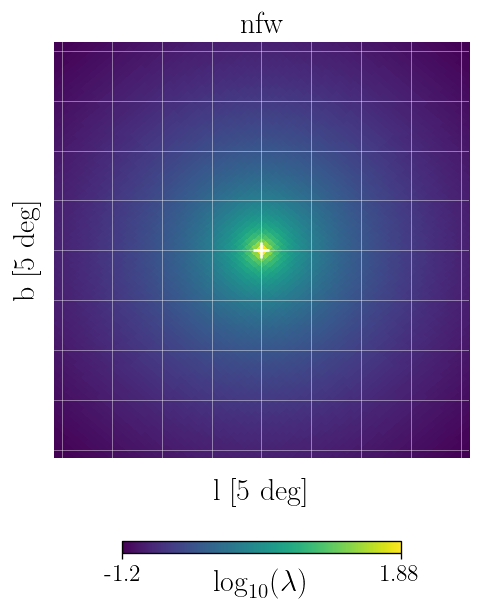

In [8]:
# load the variable templates

from templates.variable_templates import NFWTemplate

temp_nfw_full = S_nfw * jnp.asarray(ebinmodel.nfw_temp.get_NFW2_template(gamma=gamma))
temp_nfw = temp_nfw_full[~mask_p]

var_temps = [temp_nfw]
var_names = ['nfw']
var_temps_hp = []

fig = plt.figure(figsize=(6, 6), dpi= 120)
ax = fig.add_subplot(111)
plt.axes(ax)
var_temps_hp.append(ef.convert_masked_array_to_hp_array(temp_nfw, mask_p, log_option = True, nside=nside))
ef.gnomview_plot(var_temps_hp[0], title = var_names[0])

In [9]:
# create dictionary with all the templates

temp_dict = {}
temp_dict['iso'] = temp_iso
temp_dict['psc'] = temp_psc
temp_dict['bub'] = temp_bub
temp_dict['pib'] = temp_pib
temp_dict['ics'] = temp_ics
temp_dict['blg'] = temp_blg
temp_dict['nfw'] = temp_nfw

temp_dict['S_iso'] = S_iso
temp_dict['S_psc'] = S_psc
temp_dict['S_bub'] = S_bub
temp_dict['S_pib'] = S_pib
temp_dict['S_ics'] = S_ics
temp_dict['S_blg'] = S_blg
temp_dict['S_nfw'] = S_nfw
temp_dict['gamma'] = gamma

np.save(data_dir + 'all_templates_ebin' + str_ebin + '.npy', temp_dict)

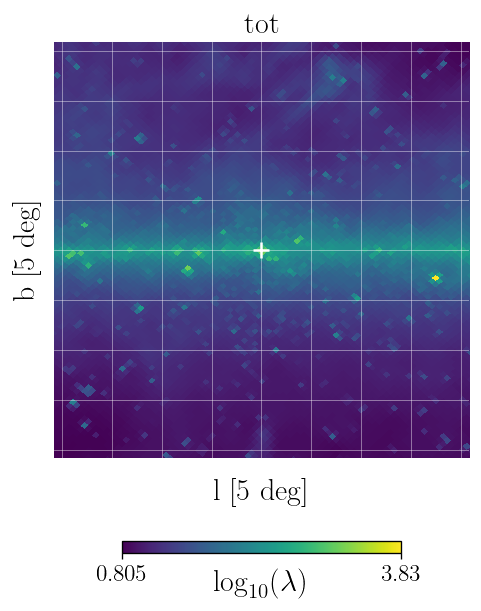

In [10]:
# templates to build synthetic data
rig_temp_select = ['iso', 'psc', 'bub'] # 'iso', 'psc', 'bub'
hyb_temp_select = ['pib', 'ics', 'blg'] # pib, ics, blg
var_temp_select = ['nfw'] # nfw, dsk

temp_names = rig_temp_select + hyb_temp_select + var_temp_select

temp_tot = np.zeros(hp.nside2npix(nside))[~mask_p]
for name in temp_names:
    temp_tot += temp_dict[name]

fig = plt.figure(figsize=(6, 6), dpi= 120)
ax = fig.add_subplot(111)
plt.axes(ax)
temp_tot_hp = ef.convert_masked_array_to_hp_array(temp_tot, mask_p, log_option = True, nside=nside)
ef.gnomview_plot(temp_tot_hp, title = 'tot')

In [11]:
from jax import jit

sim_seeds = np.arange(1000,1100)
rng_key = jax.random.PRNGKey(sim_seeds[0])

def gen_data(rng_key):
    rng_key, key = jax.random.split(rng_key)
    temp_sim = jax.random.poisson(key, temp_tot) 
    return temp_sim, rng_key

# generate many simulations by repeating different poisson draws
for sim_seed in tqdm(sim_seeds):
    temp_sim, rng_key = jit(gen_data)(rng_key)
    map_sim = np.zeros(hp.nside2npix(nside))
    map_sim[~mask_p] = temp_sim
    test_data = np.tile(map_sim, (40,1)) # make shape of simulated data compatible with real data
    pseudo_file_name = ef.make_pseudodata_file(temp_names, data_dir, create_dir = True, return_name=True, sim_seed=sim_seed)
    np.save(pseudo_file_name, test_data)

100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


In [12]:
print(pseudo_file_name)

/data/edr76/gce-gp/data/synthetic_data/canon_g1p2_fla_v2/pseudodata/sim_iso_psc_bub_pib_ics_blg_nfw/pois_draw_1099.npy


/data/edr76/gce-gp/diffuse_model_tests/../utils/ed_fcts_amarel.py:665: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))


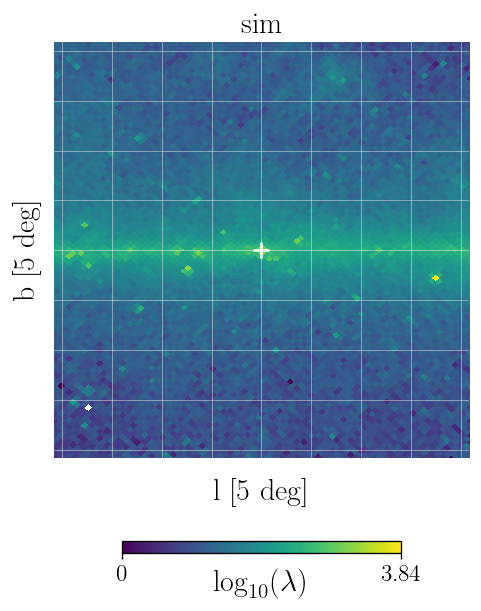

In [13]:
# load poisson draw to check that it is reasonable

sim_seed = 1011
temp_names = rig_temp_select + hyb_temp_select + var_temp_select
pseudo_file_name = ef.make_pseudodata_file(temp_names, data_dir, create_dir = True, return_name=True, sim_seed=sim_seed)
test_data = np.load(pseudo_file_name)[10][~mask_p]

fig = plt.figure(figsize=(6, 6), dpi= 120)
ax = fig.add_subplot(111)
plt.axes(ax)
temp_sim_hp = ef.convert_masked_array_to_hp_array(test_data, mask_p, log_option = True, nside=nside)
ef.gnomview_plot(temp_sim_hp, title = 'sim')

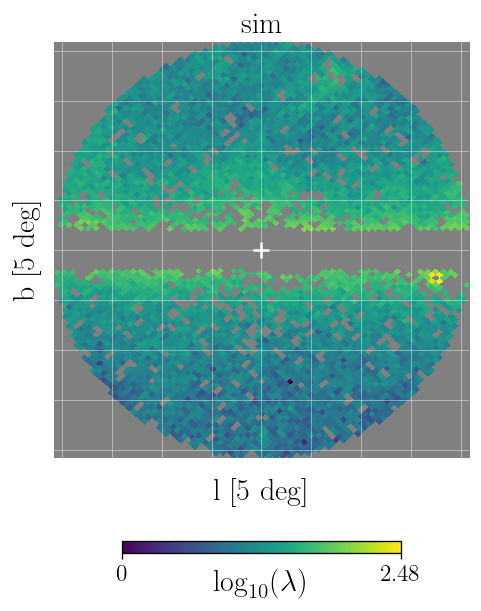

In [14]:
mask_p = ebinmodel.mask_roi_arr[ie]
test_data = np.load(pseudo_file_name)[10][~mask_p]

fig = plt.figure(figsize=(6, 6), dpi= 120)
ax = fig.add_subplot(111)
plt.axes(ax)
temp_sim_hp = ef.convert_masked_array_to_hp_array(test_data, mask_p, log_option = True, nside=nside)
ef.gnomview_plot(temp_sim_hp, title = 'sim')